<h1 align=center>Model Training</h1>

<h3>Install Packages</h3>

In [2]:
!pip install ultralytics --quiet
!pip install "ray[tune]" --quiet
!pip install -U ipywidgets --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.2 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.9.2 which is incompatible.


<h3>Imports</h3>

In [3]:
import os
import shutil
from distutils.dir_util import copy_tree

from kaggle_secrets import UserSecretsClient

from ultralytics.data.utils import autosplit
from ultralytics import YOLO
from ultralytics import settings

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


<h3>Hyperparameters</h3>

In [4]:
# HYPERPARAMETERS
# Data Split
TRAIN_FRACTION = 0.8
VAL_FRACTION = 0.1
TEST_FRACTION = 0.1

assert ((TRAIN_FRACTION + VAL_FRACTION + TEST_FRACTION) == 1.0), "Sum of split fraction != 1"

# training ephochs
EPOCHS = 50

# tracking
TRACKER = 'wandb'

# tuning
AUTOTUNE = False

<h3>Setup Trackers</h3>

In [5]:
if TRACKER == 'wandb':
    !pip install -U wandb --quiet
    
    import wandb
    
    user_secrets = UserSecretsClient()
    wandb_auth_token = user_secrets.get_secret("WANDB_AUTH_TOKEN")
    
    wandb.login(key=wandb_auth_token)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [6]:
if TRACKER == 'mlflow':
    !pip install mlflow --quiet
    !pip install pyngrok --quiet
    
    import mlflow
    from pyngrok import ngrok
    from getpass import getpass
    
    get_ipython().system_raw("mlflow ui --port 5000 --backend-store-uri runs/mlflow &")

    # Terminate open tunnels if exist
    ngrok.kill()

    user_secrets = UserSecretsClient()
    ngrok_auth_token = user_secrets.get_secret("NGROK_AUTH_TOKEN")
    ngrok.set_auth_token(ngrok_auth_token)

    # Open an HTTPs tunnel on port 5000 for http://localhost:5000
    ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
    print("MLflow Tracking UI:", ngrok_tunnel.public_url)

    # Update a setting
    settings.update({"mlflow": True})

<h3>Dataset Preparation</h3>

In [7]:
# Copy train images from kaggle input directory to kaggle output directory
dataset_source_dir = '/kaggle/input/fixed-wing-uavs/dataset-07-10-2024/'
dataset_target_dir = '/kaggle/working/dataset/'

data_yaml_source_path = '/kaggle/working/dataset/data_kaggle.yaml'
data_yaml_target_path = '/kaggle/working/data_kaggle.yaml'

os.makedirs(dataset_target_dir, exist_ok=True)
copy_tree(dataset_source_dir, dataset_target_dir)
shutil.move(data_yaml_source_path, data_yaml_target_path)

'/kaggle/working/data_kaggle.yaml'

In [8]:
# create data split
autosplit(path="/kaggle/working/dataset",
          weights = (TRAIN_FRACTION, VAL_FRACTION, TEST_FRACTION),
          annotated_only=True)

Autosplitting images from /kaggle/working/dataset, using *.txt labeled images only


100%|██████████| 891/891 [00:00<00:00, 14708.98it/s]


<h3>Model Training</h3>

In [9]:
init_overfit_params = {
    'hsv_h': 0,
    'hsv_s': 0,
    'hsv_v': 0,
    'degrees': 0,
    'translate': 0,
    'scale': 0,
    'shear': 0,
    'perspective': 0,
    'flipud': 0,
    'fliplr': 0,
    'bgr': 0,
    'mosaic': 0,
    'mixup': 0,
    'copy_paste': 0,
    'erasing': 0,
    'crop_fraction': 0
}

In [10]:
# use pre-trained yolov11 model
model = YOLO("yolo11n.pt")

100%|██████████| 5.35M/5.35M [00:00<00:00, 22.4MB/s]


In [11]:
if AUTOTUNE == True:
    import os
    os.environ['RAY_CHDIR_TO_TRIAL_DIR'] = '0'
    from ray import tune
    param_space = {
                    # 'optimizer': tune.choice(['SGD', 'Adam', 'AdamW', 'NAdam', 'RAdam', 'RMSProp']),
                   #"lr0": tune.loguniform(1e-3, 1e-1),
                   #"lrf": tune.loguniform(0.01, 1.0),  # final OneCycleLR learning rate (lr0 * lrf)
                   #"momentum": tune.loguniform(0.9, 0.999),  # SGD momentum/Adam beta1
                   #"weight_decay": tune.uniform(0.0, 0.001),  # optimizer weight decay 5e-4
                   #"warmup_epochs": tune.uniform(0.0, 5.0),  # warmup epochs (fractions ok)
                   #"warmup_momentum": tune.uniform(0.0, 0.95),  # warmup initial momentum
                   "box": tune.loguniform(0.01, 1.0),  # box loss gain
                   "cls": tune.loguniform(0.2, 2.0),  # cls loss gain (scale with pixels)
                   }
    
    results = model.tune(data="/kaggle/working/data_kaggle.yaml",
                         use_ray=True,
                         space=param_space,
                         epochs=EPOCHS,
                         gpu_per_trial=1,
                         project='fixed-wing-uavs',
                         name='box-vs-class-loss',
                         save=True)
else:
    import wandb
    from wandb.integration.ultralytics import add_wandb_callback
    
    wandb.init(project='fixed-wing-uavs', name='initial_overfit')
    add_wandb_callback(model, enable_model_checkpointing=True)
    
    results = model.train(data="/kaggle/working/data_kaggle.yaml",
                          epochs=EPOCHS,
                          project='fixed-wing-uavs',
                          name='initial_overfit',
                          **init_overfit_params
                         )
    
    #wandb.finish()

wandb: WARNING This integration is tested and supported for ultralytics v8.0.238 and below.
wandb: WARNING             Please report any issues to https://github.com/wandb/wandb/issues with the tag `yolov8`.
wandb: Currently logged in as: amit-hershkovitz (amit-hershkovitz-technion-israel-institute-of-technology). Use `wandb login --relogin` to force relogin


Ultralytics 8.3.23 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/working/data_kaggle.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=fixed-wing-uavs, name=initial_overfit, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels

100%|██████████| 755k/755k [00:00<00:00, 4.60MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/working/dataset... 590 images, 0 backgrounds, 0 corrupt: 100%|██████████| 590/590 [00:00<00:00, 849.40it/s]


train: New cache created: /kaggle/working/dataset.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/dataset... 69 images, 0 backgrounds, 0 corrupt: 100%|██████████| 69/69 [00:00<00:00, 857.80it/s]

val: New cache created: /kaggle/working/dataset.cache


Plotting labels to fixed-wing-uavs/initial_overfit/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to fixed-wing-uavs/initial_overfit
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.62G      1.151      2.943       1.57         14        640: 100%|██████████| 37/37 [00:09<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]

                   all         69         82    0.00896       0.89       0.45      0.265
Ultralytics 8.3.23 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.65G      1.169      2.268      1.528         16        640: 100%|██████████| 37/37 [00:07<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.10it/s]

                   all         69         82      0.626      0.245      0.403      0.179


Generating Visualizations for batch-1/1:   0%|          | 0/5 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.64G      1.239      2.067      1.563         15        640: 100%|██████████| 37/37 [00:07<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.41it/s]

                   all         69         82      0.365      0.512      0.363      0.156


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/5 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.65G       1.26      1.785      1.591         14        640: 100%|██████████| 37/37 [00:07<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.77it/s]

                   all         69         82      0.234      0.329      0.192      0.077


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.65G      1.154      1.583      1.477         14        640: 100%|██████████| 37/37 [00:07<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.32it/s]


                   all         69         82      0.607      0.376      0.413      0.193


Generating Visualizations for batch-1/1:   0%|          | 0/5 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.64G      1.023      1.303      1.371         14        640: 100%|██████████| 37/37 [00:07<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.60it/s]

                   all         69         82      0.566      0.634      0.561      0.306


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/5 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.65G     0.9925      1.167      1.347         14        640: 100%|██████████| 37/37 [00:07<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.10it/s]

                   all         69         82      0.499      0.546      0.507      0.298


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.65G     0.9249       1.07      1.298         14        640: 100%|██████████| 37/37 [00:07<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.46it/s]


                   all         69         82      0.671      0.646      0.643      0.371


Generating Visualizations for batch-1/1:   0%|          | 0/5 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.65G      0.888      1.003       1.26         14        640: 100%|██████████| 37/37 [00:07<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.50it/s]

                   all         69         82      0.723      0.646      0.693      0.366


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/5 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.64G      0.812     0.8789      1.181         18        640: 100%|██████████| 37/37 [00:07<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.04it/s]

                   all         69         82      0.614      0.646      0.619      0.383


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.65G     0.7524     0.7914      1.147         14        640: 100%|██████████| 37/37 [00:07<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.32it/s]


                   all         69         82      0.727      0.649      0.674      0.354


Generating Visualizations for batch-1/1:   0%|          | 0/5 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.65G     0.7203     0.7341      1.119         15        640: 100%|██████████| 37/37 [00:07<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.59it/s]

                   all         69         82      0.862      0.598      0.735      0.452


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/5 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.65G     0.6631     0.6796      1.067         15        640: 100%|██████████| 37/37 [00:07<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.59it/s]

                   all         69         82      0.673       0.61       0.63      0.405


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.64G     0.6204     0.6367      1.036         14        640: 100%|██████████| 37/37 [00:07<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.52it/s]

                   all         69         82      0.813      0.695      0.739      0.449


Generating Visualizations for batch-1/1:   0%|          | 0/5 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.65G     0.5734     0.5616      1.002         15        640: 100%|██████████| 37/37 [00:07<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.97it/s]

                   all         69         82      0.719      0.744      0.708       0.46


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/5 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.64G     0.5105     0.5148     0.9584         15        640: 100%|██████████| 37/37 [00:07<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.59it/s]

                   all         69         82      0.714      0.639      0.653      0.378


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.65G     0.5116     0.4853     0.9512         17        640: 100%|██████████| 37/37 [00:07<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.77it/s]

                   all         69         82       0.74      0.646      0.676      0.419


Generating Visualizations for batch-1/1:   0%|          | 0/5 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.64G     0.4818     0.4607     0.9421         14        640: 100%|██████████| 37/37 [00:07<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.24it/s]

                   all         69         82      0.805      0.671      0.699      0.413


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/5 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.65G      0.429     0.4174     0.9097         14        640: 100%|██████████| 37/37 [00:07<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.04it/s]

                   all         69         82      0.835      0.619      0.735      0.483


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.65G     0.4303     0.4068      0.904         14        640: 100%|██████████| 37/37 [00:07<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.52it/s]

                   all         69         82      0.842      0.634      0.727      0.494


Generating Visualizations for batch-1/1:   0%|          | 0/5 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.65G     0.4148     0.3886     0.8956         21        640: 100%|██████████| 37/37 [00:07<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.06it/s]

                   all         69         82      0.787      0.683      0.765      0.521


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/5 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.64G     0.3669     0.3596      0.875         14        640: 100%|██████████| 37/37 [00:07<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.20it/s]

                   all         69         82      0.831      0.646      0.732      0.489


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.65G     0.3472      0.339     0.8678         14        640: 100%|██████████| 37/37 [00:07<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.59it/s]

                   all         69         82      0.885      0.646      0.776      0.508


Generating Visualizations for batch-1/1:   0%|          | 0/5 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.65G     0.3307     0.3224     0.8577         14        640: 100%|██████████| 37/37 [00:07<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.15it/s]

                   all         69         82       0.75      0.744      0.749      0.479


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/5 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.65G     0.3142     0.3099     0.8449         14        640: 100%|██████████| 37/37 [00:07<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.31it/s]

                   all         69         82      0.826      0.683      0.762      0.494


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.64G     0.3108     0.2984     0.8492         14        640: 100%|██████████| 37/37 [00:07<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.65it/s]

                   all         69         82      0.847      0.622      0.753      0.514


Generating Visualizations for batch-1/1:   0%|          | 0/5 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.65G     0.2857     0.2746     0.8375         14        640: 100%|██████████| 37/37 [00:07<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.93it/s]

                   all         69         82      0.836      0.659      0.742      0.475


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/5 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.65G     0.2626     0.2617     0.8284         14        640: 100%|██████████| 37/37 [00:07<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.80it/s]


                   all         69         82      0.811       0.72      0.775      0.499


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.65G     0.2444     0.2443     0.8225         17        640: 100%|██████████| 37/37 [00:07<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.53it/s]

                   all         69         82      0.849      0.671      0.739      0.509


Generating Visualizations for batch-1/1:   0%|          | 0/5 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.64G     0.2334     0.2329     0.8183         14        640: 100%|██████████| 37/37 [00:07<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.49it/s]

                   all         69         82       0.83      0.646      0.747      0.488


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/5 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.65G     0.2288     0.2278     0.8163         18        640: 100%|██████████| 37/37 [00:07<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.35it/s]

                   all         69         82      0.765      0.707      0.753      0.532


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.65G     0.2183     0.2197     0.8147         14        640: 100%|██████████| 37/37 [00:07<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.53it/s]

                   all         69         82      0.841      0.744      0.771      0.539


Generating Visualizations for batch-1/1:   0%|          | 0/5 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.65G        0.2     0.2026     0.8064         14        640: 100%|██████████| 37/37 [00:07<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.92it/s]

                   all         69         82      0.814      0.671      0.756      0.517


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/5 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.64G     0.1921      0.192     0.8038         14        640: 100%|██████████| 37/37 [00:07<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.76it/s]

                   all         69         82      0.839      0.697      0.792      0.533


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.67G     0.1748     0.1831      0.799         17        640: 100%|██████████| 37/37 [00:07<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.71it/s]

                   all         69         82      0.817      0.683      0.763      0.525


Generating Visualizations for batch-1/1:   0%|          | 0/5 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.65G     0.1615     0.1734      0.798         15        640: 100%|██████████| 37/37 [00:07<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.33it/s]

                   all         69         82      0.845      0.732      0.791      0.542


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/5 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.65G      0.159     0.1639     0.7953         19        640: 100%|██████████| 37/37 [00:07<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.06it/s]

                   all         69         82      0.792      0.756      0.801      0.537


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.64G      0.152     0.1585     0.7972         15        640: 100%|██████████| 37/37 [00:07<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.44it/s]

                   all         69         82      0.884      0.683      0.799      0.526


Generating Visualizations for batch-1/1:   0%|          | 0/5 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.65G     0.1488     0.1543     0.7954         17        640: 100%|██████████| 37/37 [00:07<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.00it/s]

                   all         69         82      0.777      0.707      0.779      0.517


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/5 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.65G     0.1479     0.1503     0.7924         14        640: 100%|██████████| 37/37 [00:07<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.72it/s]


                   all         69         82      0.835      0.695      0.794       0.53


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.65G     0.1383     0.1414     0.7919         14        640: 100%|██████████| 37/37 [00:08<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.17it/s]

                   all         69         82      0.886      0.683      0.794      0.564


Generating Visualizations for batch-1/1:   0%|          | 0/5 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.64G     0.1315     0.1381      0.788         14        640: 100%|██████████| 37/37 [00:07<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.05it/s]

                   all         69         82      0.869      0.671      0.782      0.542


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/5 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.65G     0.1239      0.133     0.7879         17        640: 100%|██████████| 37/37 [00:07<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.25it/s]

                   all         69         82      0.849      0.695      0.791      0.534


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.65G     0.1215     0.1291     0.7873         15        640: 100%|██████████| 37/37 [00:07<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.67it/s]


                   all         69         82      0.863      0.695      0.795      0.537


Generating Visualizations for batch-1/1:   0%|          | 0/5 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.65G     0.1118     0.1218     0.7849         14        640: 100%|██████████| 37/37 [00:07<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.02it/s]

                   all         69         82      0.892       0.72      0.807      0.536


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/5 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.65G      0.108     0.1166     0.7854         16        640: 100%|██████████| 37/37 [00:07<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.27it/s]

                   all         69         82      0.844      0.707      0.787      0.536


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.65G    0.09809     0.1121     0.7851         15        640: 100%|██████████| 37/37 [00:07<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.49it/s]

                   all         69         82      0.821      0.727      0.794      0.531


Generating Visualizations for batch-1/1:   0%|          | 0/5 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.65G     0.0897     0.1056      0.784         15        640: 100%|██████████| 37/37 [00:07<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.91it/s]

                   all         69         82      0.838      0.694      0.784      0.532


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/5 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.65G    0.08784     0.1039     0.7833         14        640: 100%|██████████| 37/37 [00:07<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.13it/s]

                   all         69         82      0.874       0.68      0.791      0.533


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.64G    0.08054    0.09826     0.7815         15        640: 100%|██████████| 37/37 [00:07<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.83it/s]

                   all         69         82       0.77      0.756       0.79      0.544


Generating Visualizations for batch-1/1:   0%|          | 0/5 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


50 epochs completed in 0.387 hours.
Optimizer stripped from fixed-wing-uavs/initial_overfit/weights/last.pt, 5.5MB
Optimizer stripped from fixed-wing-uavs/initial_overfit/weights/best.pt, 5.5MB

Validating fixed-wing-uavs/initial_overfit/weights/best.pt...
Ultralytics 8.3.23 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.95it/s]


                   all         69         82      0.886      0.683      0.793      0.564


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Speed: 0.1ms preprocess, 2.7ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to fixed-wing-uavs/initial_overfit


In [12]:
if AUTOTUNE == True:
    best_result = results.get_best_result(metric='metrics/mAP50-95(B)', mode='max')
    print(best_result)

    import pickle as p
    with open(f'{best_result.path}/params.pkl', 'rb') as f:
        params = p.load(f)

    print(params)

<h3> Model Evaluation </h3>

In [13]:
results_train = model.val(split='train',
                          name='iof-train-eval')
results_val = model.val(split='val',
                        name='iof-val-eval')
results_test = model.val(split='test',
                         name='iof-test-eval')

Ultralytics 8.3.23 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /kaggle/working/dataset... 590 images, 0 backgrounds, 0 corrupt: 100%|██████████| 590/590 [00:00<00:00, 894.46it/s]

val: New cache created: /kaggle/working/dataset.cache



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:05<00:00,  7.05it/s]


                   all        590        655      0.994      0.973      0.988      0.961


Generating Visualizations for batch-1/1:   0%|          | 0/16 [00:00<?, ?it/s]

Speed: 0.1ms preprocess, 3.2ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to fixed-wing-uavs/initial_overfit2
Ultralytics 8.3.23 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


val: Scanning /kaggle/working/dataset... 69 images, 0 backgrounds, 0 corrupt: 100%|██████████| 69/69 [00:00<00:00, 932.85it/s]

val: New cache created: /kaggle/working/dataset.cache



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


                   all         69         82      0.868      0.659      0.779      0.543


Generating Visualizations for batch-1/1:   0%|          | 0/16 [00:00<?, ?it/s]

Speed: 0.2ms preprocess, 4.5ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to fixed-wing-uavs/initial_overfit3
Ultralytics 8.3.23 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


val: Scanning /kaggle/working/dataset... 76 images, 0 backgrounds, 0 corrupt: 100%|██████████| 76/76 [00:00<00:00, 899.13it/s]

val: New cache created: /kaggle/working/dataset.cache



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]


                   all         76         83      0.857      0.793      0.841      0.644


Generating Visualizations for batch-1/1:   0%|          | 0/16 [00:00<?, ?it/s]

Speed: 0.2ms preprocess, 6.4ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to fixed-wing-uavs/initial_overfit4


Text(0.5, 1.0, 'mAP50')

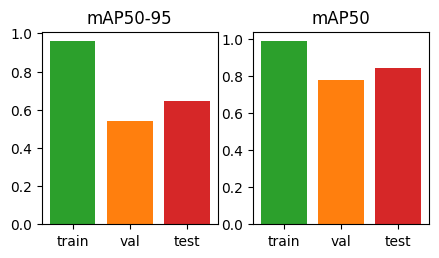

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(5,2.5))

ax[0].bar(['train', 'val', 'test'],
          [results_train.box.map, results_val.box.map, results_test.box.map],   
          color=['tab:green','tab:orange','tab:red'])
ax[1].bar(['train', 'val', 'test'],
             [results_train.box.map50, results_val.box.map50, results_test.box.map50],
             color=['tab:green','tab:orange','tab:red'])

ax[0].set_title('mAP50-95')
ax[1].set_title('mAP50')

In [ ]:
#import random
#
#def generate_random_image_paths(num_paths):
#    with open("/kaggle/working/autosplit_test.txt", "r") as f:
#        data = f.read().replace('./', '/kaggle/working/').split('\n')
#        data = data[:-1]
#    
#    generated_paths = []
#    image_nums = random.sample(range(0, len(data)), num_paths)
#
#    for i in image_nums:
#        generated_paths.append(data[i])
#        
#    return generated_paths

In [ ]:
#paths = generate_random_image_paths(60)
#print(paths)

In [ ]:
#model = YOLO('/kaggle/working/runs/detect/different_split/weights/best.pt')
#
#for result in results:
#    result.show()  # display to screen   